# Media Matters Worldwide Bayesian Media Mix Model Template

This notebook contains a media mix model, created from methods similar to __[this paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf)__. The model informs a budget optimizer, which optimizes the budget for spending in advertising media channels in the short-term.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt
from functools import reduce
from yellowbrick.regressor import residuals_plot
from transformations import transform_one_column, select_best_feature, feature_imp_random_forest

import time
import datetime
import ipywidgets as widgets
from ipywidgets import FileUpload

from IPython.display import display
from IPython.display import FileLink
import io
import re
from scipy.optimize import minimize, LinearConstraint

import openpyxl
import xlrd

import holidays

# import panel as pn
# pn.extension()

from helper import *
from bayesian import *

import arviz as az

# Data Collection

### your inputs start

In [3]:
client = "Proactiv" # name of the client
use_excel = True # true corresponds to files are excel files, or .xlsx | false corresponds to .csv
granularity = True # true corresponds to daily 
data_type = "SALES DATA" # leave unchanged
sales_fileName = "./../Proactiv_OrderData_2022.03.23.xlsx" # file name of the sales data
ad_fileName = "./../Proactiv_MediaData_2022.03.23.xlsx" # file name of the advertising/media mix data

## DO NOT EDIT BELOW ##
try:
    path = f"{client}_{str(datetime.date.today())}"
    os.makedirs(path)
except:
    pass

### your inputs end

In [4]:
sales_df_cleaned = read_sales_data(sales_fileName, use_excel, data_type, granularity)

COLUMNS of SALES DATA: ['Campaign Geo' 'Day' 'Visits' 'Orders' 'Conv Rate (Adobe)'
 'Revenue (Adobe)']


COUNTRY | [column-name/NONE] Campaign Geo
DAY | [column-name] Day
RESPONSE VARIABLE | [column-name] Orders


This process will be repeated for the advertising media mix data.

In [5]:
ad_df, data_dict = read_ad_data(ad_fileName, sales_df_cleaned, use_excel)

['Day' 'Campaign Geo' 'Channel' 'Publisher' 'Media Objective' 'Audience'
 'Ad Type' 'Media Cost' 'Impressions']


COUNTRY | [column-name/NONE] Campaign Geo
MEDIA COST | [column-name/NONE] Media Cost
IMPRESSIONS | [column-name/NONE] Impressions


***

# Modeling

### your inputs start

In [6]:
country = "US" # specify country name, must be consistent with sales/ad dataset
target = 'Orders' # target variable specified above
combine_columns = True # true if you wish to combine too-granular columns, false if leave data as is

### your inputs end

In [7]:
df = read_data_from_data_dict(data_dict, country, target, combine_columns=True)

In [8]:
initial_model = BayesianMixModel(client=client, country=country, target=target, path=path)
X, y = df.drop(columns=[target]), df[target]
xtrain, xval, ytrain, yval = train_test_split(X,y, test_size=0.1, shuffle=False)

In [9]:
initial_model.fit(xtrain, ytrain, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef, noise, base, car_youtube_media_cost, sat_youtube_media_cost, coef_youtube_media_cost, car_twitch_media_cost, sat_twitch_media_cost, coef_twitch_media_cost, car_tinder_media_cost, sat_tinder_media_cost, coef_tinder_media_cost, car_thetradedesk_media_cost, sat_thetradedesk_media_cost, coef_thetradedesk_media_cost, car_snapchat_media_cost, sat_snapchat_media_cost, coef_snapchat_media_cost, car_radio_media_cost, sat_radio_media_cost, coef_radio_media_cost, car_pinterest_media_cost, sat_pinterest_media_cost, coef_pinterest_media_cost, car_lineartv_media_cost, sat_lineartv_media_cost, coef_lineartv_media_cost, car_influential_media_cost, sat_influential_media_cost, coef_influential_media_cost, car_googlesearch_media_cost, sat_googlesearch_media_cost, coef_googlesearch_media_cost, car_facebook_media_cost, sat_facebook_media_cost, coef_facebook_media_cost, car_dv3

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 924 seconds.
There were 748 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6096600205623871, but should be close to 0.8. Try to increase the number of tuning steps.
There were 242 divergences after tuning. Increase `target_accept` or reparameterize.
There were 491 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.707520172949698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 880 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35935468905115714, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estim

## [Training, Validation] Model Mean Absolute Percentage Error

In [10]:
train_mape, val_mape, train_r2, val_r2 = calculate_mape(initial_model, xtrain, ytrain, xval, yval)
print(f"TRAIN MEAN ABSOLUTE PERCENTAGE ERROR = {train_mape}")
print(f"VALIDATION MEAN ABSOLUTE PERCENTAGE ERROR = {val_mape}")

print(f"TRAIN r2-score = {train_r2}")
print(f"VALIDATION r2-score = {val_r2}")

TRAIN MEAN ABSOLUTE PERCENTAGE ERROR = 0.1599746601215079
VALIDATION MEAN ABSOLUTE PERCENTAGE ERROR = 0.24563836062811994
TRAIN r2-score = 0.7348416227290845
VALIDATION r2-score = -4.414649869926108


training plots

## [Training] Model Fit Time Series

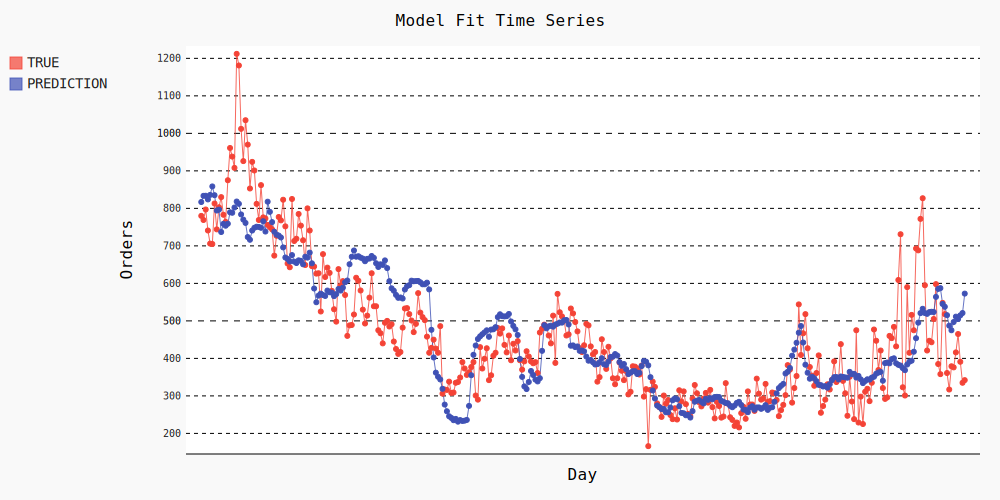

In [11]:
initial_model.lineplot()

## [Training] Model Predictions vs Observations

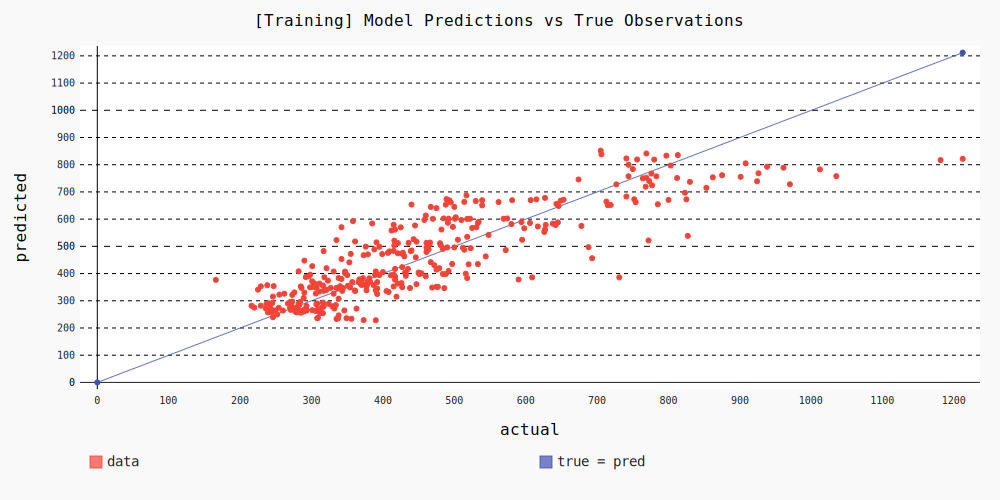

In [12]:
initial_model.scatterplot()

## [Validation] Model Fit Time Series

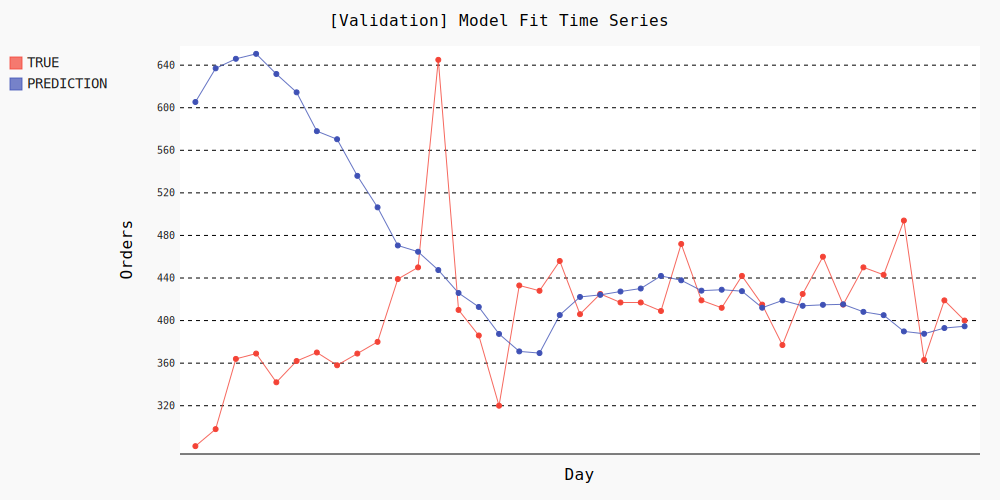

In [13]:
validation_lineplot(initial_model, xval, yval, target)

## [Validation] Model Predictions vs Observations

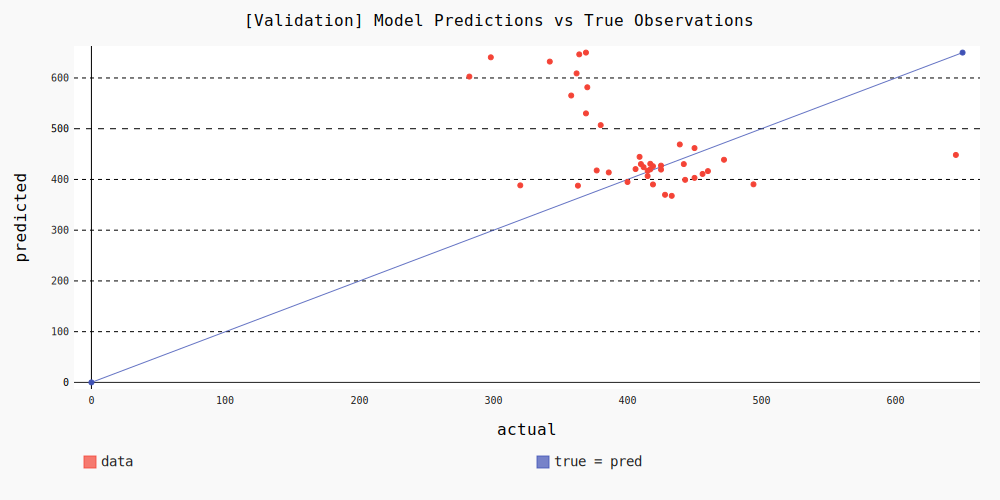

In [14]:
validation_scatterplot(initial_model, xval, yval)

## [Training] Attribution Graph

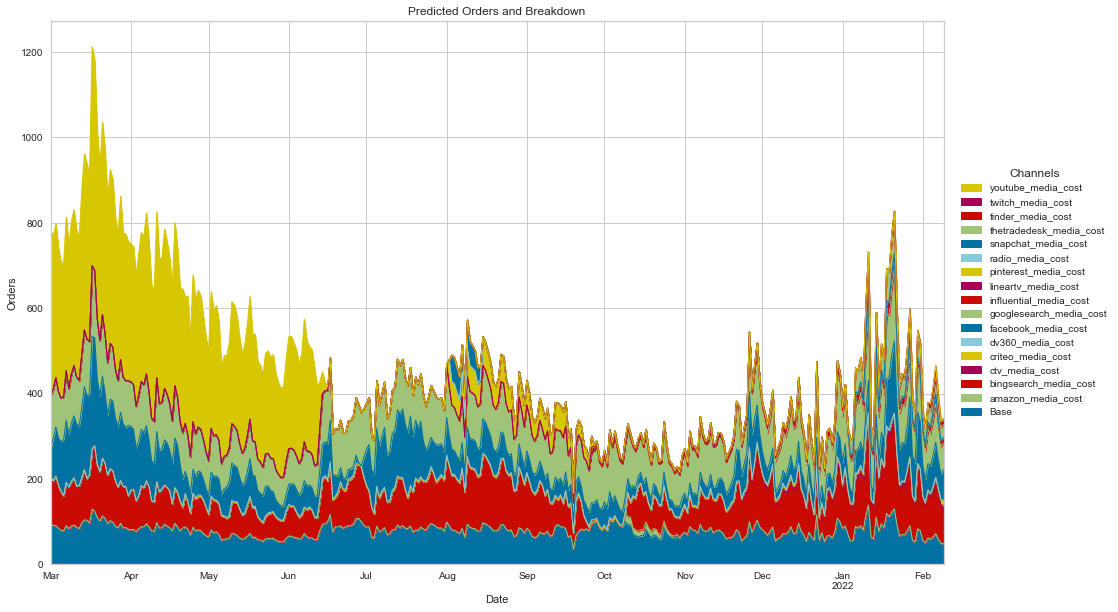

In [15]:
initial_model.attribution()

## [Training] Saturation Curves

In [24]:
channel_bar(initial_model, calculate_current_saturations(initial_model), title="Current Channel Saturation (1.0 implies fully saturated)")

NameError: name 'initial_model' is not defined

# Bayesian Optimization

### Train Model on All Data

In [26]:
final_model = BayesianMixModel(client=client, country=country, target=target, path=path)
final_model.fit(X, y, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef, noise, base, car_youtube_media_cost, sat_youtube_media_cost, coef_youtube_media_cost, car_twitch_media_cost, sat_twitch_media_cost, coef_twitch_media_cost, car_tinder_media_cost, sat_tinder_media_cost, coef_tinder_media_cost, car_thetradedesk_media_cost, sat_thetradedesk_media_cost, coef_thetradedesk_media_cost, car_snapchat_media_cost, sat_snapchat_media_cost, coef_snapchat_media_cost, car_radio_media_cost, sat_radio_media_cost, coef_radio_media_cost, car_pinterest_media_cost, sat_pinterest_media_cost, coef_pinterest_media_cost, car_lineartv_media_cost, sat_lineartv_media_cost, coef_lineartv_media_cost, car_influential_media_cost, sat_influential_media_cost, coef_influential_media_cost, car_googlesearch_media_cost, sat_googlesearch_media_cost, coef_googlesearch_media_cost, car_facebook_media_cost, sat_facebook_media_cost, coef_facebook_media_cost, car_dv3

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1040 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
There were 446 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6789765131823734, but should be close to 0.8. Try to increase the number of tuning steps.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## One-Day Recommendation

This can guide longer-term decision making

### your inputs start

In [27]:
budget = 20000 # specify the budget for a day

### your inputs end

In [30]:
xs = cvx_optimize_mean(final_model, budget=20000)

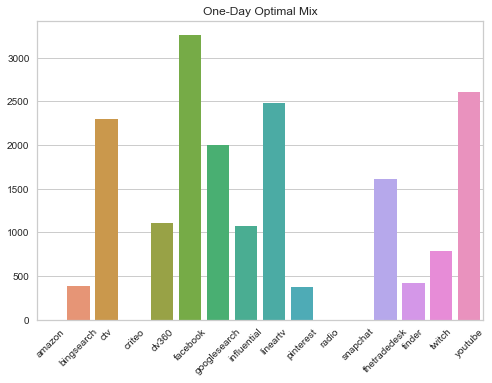

In [32]:
channel_bar(final_model, xs, title="One-Day Optimal Mix")

## One-Month Recommendation

In [33]:
x_opt_month = bayesian_optimize_month(final_model, budget=budget, days=10)

KeyboardInterrupt: 

In [ ]:
sns.lineplot(data=pd.DataFrame(columns=final_model.feature_names_in_, data=x_opt_month))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
plt.title("Optimized Budget for Month")
plt.xlabel("Days")
plt.ylabel("Spending ($)");

# Forecasting

In [34]:
X.columns

Index(['amazon_media_cost', 'bingsearch_media_cost', 'ctv_media_cost',
       'criteo_media_cost', 'dv360_media_cost', 'facebook_media_cost',
       'googlesearch_media_cost', 'influential_media_cost',
       'lineartv_media_cost', 'pinterest_media_cost', 'radio_media_cost',
       'snapchat_media_cost', 'thetradedesk_media_cost', 'tinder_media_cost',
       'twitch_media_cost', 'youtube_media_cost'],
      dtype='object')

To forecast for one-month (or any time length greater than 1 day), write an excel spreadsheet or .csv file with the above columns in that **EXACT** order. Set `use_excel` to `True` if the file is an excel file, else set it to `False`.

In [35]:
data_type = "ad data [forecasting]"
use_excel = True

In [36]:
forecast_as_bytes = input_file(data_type, use_excel=use_excel)

FileUpload(value={}, accept='.xlsx', description='Upload')

In [44]:
forecast_sales_df = parse_file(forecast_as_bytes, data_type, use_excel=use_excel)

Thanks for uploading the ad data [forecasting]. I will display the dataframe in 2 seconds


,amazon,bing,ctv,criteo,dv360,facebook,google,influential,linear_tv,pinterest,radio_media,snapchat,thetradedesk,tinder,twitch,youtube
0,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
1,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
2,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
3,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
4,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
5,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
6,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
7,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
8,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
9,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500


Is the header correct [y/n] y


SUCCESS -- PROCEED


In [46]:
forecast_sales_df = forecast_sales_df * 0

In [47]:
forecast_sales_df = forecast_sales_df.iloc[:, np.arange(len(get_media_vars(X)))]
forecast_sales_df.columns = get_media_vars(X)

In [51]:
final_predictions = final_model.predict(forecast_sales_df)

In [52]:
forecast_output_df = pd.DataFrame(columns=["predictions"], data=final_predictions)
forecast_output_df.to_excel(f"{final_model.path}/{final_model.client}_forecast_predictions.xlsx")

In [53]:
forecast_output_df

,predictions
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN
